In [3]:
import torch
import torch.nn as nn
import pandas as pd
import os
from torch.utils.data import Dataset
import random
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
import math
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
import pickle

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# import os

# # Đường dẫn đến tệp ZIP trong Google Drive
# zip_path = '/content/drive/MyDrive/TLCN/Skeletons.zip'
# extract_path = '/content/drive/MyDrive/TLCN/Skeletons'

# # Tạo thư mục nếu chưa tồn tại
# os.makedirs(extract_path, exist_ok=True)

# # Giải nén tệp ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Giải nén hoàn tất!")

In [5]:
DATA_PATH = '/content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/'
LABEL_PATH = '/content/drive/MyDrive/TLCN/class_list.txt'
NUM_FRAMES = 32

In [6]:
# Tạo hai ánh xạ từ file
def load_label_mappings(label_path):
    idx_to_label = {}
    label_to_idx = {}

    with open(label_path, 'r') as file:
        for line in file:
            idx, label = line.strip().split('\t')  # Dòng được phân tách bằng tab (\t)
            idx = int(idx)  # Chuyển số thành integer
            idx_to_label[idx] = label
            label_to_idx[label] = idx

    return idx_to_label, label_to_idx

# Sử dụng ánh xạ
idx_to_label, label_to_idx = load_label_mappings(LABEL_PATH)

Lớp Dataset đọc dữ liệu từ các folder

In [7]:
class VideoDataset(Dataset):
    def __init__(self, data_path, transform=None, max_folders=100):
        """
        Dataset class for loading video data.

        Args:
            data_path (str): Path to the root directory containing video data.
            label_path (str): Path to the file containing label mappings.
            transform (callable, optional): Transformation to apply to the video data.
            max_folders (int, optional): Maximum number of folders to process. Default is None (process all).
        """
        self.videos = []
        self.labels = []
        self.transform = transform
        self.label_to_idx, self.idx_to_label =label_to_idx, idx_to_label

        folder_count = 0

        for ii in range(max_folders):
            folder_count += 1
            if max_folders and folder_count > max_folders:
                break
            folder_name = self.idx_to_label[ii]
            folder_path = os.path.join(data_path, folder_name)
            print(f'Processing folder {folder_count}:', folder_path)

            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    if filename.endswith('.csv'):
                        file_path = os.path.join(folder_path, filename)
                        df = pd.read_csv(file_path)

                        data = df.iloc[:, 1:].values

                        V = data.shape[1] // 3  # Mỗi khớp có 3 giá trị (x, y, z)
                        T = data.shape[0]  # Số khung hình (frames)
                        C = 3

                        video_data = data.reshape(T, V, C)

                        self.videos.append(video_data)

                        self.labels.append(folder_name)

        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        label = self.labels[idx]

        if self.transform:
            video = self.transform(video)

        return video, label
    def get_label_from_idx(self, idx):
        """
        Get the original label (string) from an index.

        Args:
            idx (int): Index of the label.

        Returns:
            str: The original label.
        """
        return self.idx_to_label[idx]

Lớp RandomFrameSampler để tạo ra các mẫu dữ liệu được cắt ngẫu nhiêu nhằm tăng độ đa dạng của dữ liệu, giúp mô hình học các đặc trưng tổng quát hơn

In [8]:
import random
import numpy as np
import torch

class RandomFrameSampler:
    def __init__(self, num_frames, jitter=0, threshold=0.1, dense_factor=2, scales=[1, 2]):
        self.num_frames = num_frames
        self.jitter = jitter
        self.threshold = threshold
        self.dense_factor = dense_factor
        self.scales = scales
        self.modes = ["random", "visibility_weighted", "dense", "keyframe", "multi_scale", "optical_flow"]

    def pad_or_trim_frames(self, frames):
        """ Đảm bảo đầu ra có đúng `num_frames` khung hình """
        T, V, C = frames.shape
        if T < self.num_frames:
            repeat_times = (self.num_frames + T - 1) // T
            frames = np.tile(frames, (repeat_times, 1, 1))[:self.num_frames]
        elif T > self.num_frames:
            selected_indices = np.linspace(0, T, self.num_frames, endpoint=False, dtype=int)
            frames = frames[selected_indices]
        return frames

    def __call__(self, video):
        # Chọn ngẫu nhiên một phương pháp lấy mẫu
        mode = random.choice(self.modes)
        T, V, C = video.shape
        sampled_video = video

        if mode == "visibility_weighted":
            visibility_scores = video[:, :, 2].mean(axis=1)
            high_visibility_indices = np.argsort(-visibility_scores)
            selected_indices = high_visibility_indices[:self.num_frames]
            sampled_video = video[np.sort(selected_indices)]

        elif mode == "dense":
            dense_num_frames = min(T, self.num_frames * self.dense_factor)
            intervals = np.linspace(0, T, dense_num_frames, endpoint=False, dtype=int)
            dense_sampled_video = video[intervals]

            if dense_sampled_video.shape[0] % (self.num_frames * V * C) != 0:
                sampled_video = self.pad_or_trim_frames(dense_sampled_video)
            else:
                sampled_video = dense_sampled_video.reshape(self.num_frames, -1, V, C).mean(axis=1)

        elif mode == "keyframe":
            diffs = np.linalg.norm(np.diff(video, axis=0), axis=(1, 2))
            keyframe_indices = np.where(diffs > self.threshold)[0]
            if len(keyframe_indices) < self.num_frames:
                sampled_indices = np.random.choice(T, self.num_frames, replace=True)
            else:
                sampled_indices = np.linspace(0, len(keyframe_indices), self.num_frames, endpoint=False, dtype=int)
                sampled_indices = keyframe_indices[sampled_indices]
            sampled_video = video[np.sort(sampled_indices)]

        elif mode == "multi_scale":
            sampled_videos = []
            for scale in self.scales:
                interval = max(1, T // (self.num_frames * scale))
                indices = np.arange(0, T, interval)[:self.num_frames]
                sampled_videos.append(video[indices])
            sampled_video = np.concatenate(sampled_videos, axis=0)
            sampled_video = self.pad_or_trim_frames(sampled_video)

        elif mode == "optical_flow":
            optical_flow = np.linalg.norm(np.diff(video, axis=0), axis=(1, 2))
            flow_indices = np.where(optical_flow > self.threshold)[0]
            if len(flow_indices) < self.num_frames:
                sampled_indices = np.random.choice(T, self.num_frames, replace=True)
            else:
                sampled_indices = np.linspace(0, len(flow_indices), self.num_frames, endpoint=False, dtype=int)
                sampled_indices = flow_indices[sampled_indices]
            sampled_video = video[np.sort(sampled_indices)]

        else:
            if T >= self.num_frames:
                intervals = np.linspace(0, T, self.num_frames, endpoint=False, dtype=int)
                selected_indices = [min(random.choice(range(start, min(start + (T // self.num_frames), T))) +
                                    random.randint(-self.jitter, self.jitter), T-1)
                                    for start in intervals]
                sampled_video = video[selected_indices]
            else:
                sampled_video = video[np.random.choice(T, self.num_frames, replace=True)]

        sampled_video = self.pad_or_trim_frames(sampled_video)

        return torch.tensor(sampled_video, dtype=torch.float32)


Thiết kế mạng LSTM kết hợp với Multi Head Attention

In [9]:
  import torch
  import torch.nn as nn

  class MultiHeadAttention(nn.Module):
      def __init__(self, embed_size, num_heads):
          super(MultiHeadAttention, self).__init__()
          self.attention = nn.MultiheadAttention(embed_size, num_heads)

      def forward(self, x, mask=None):
          # Chuyển đổi đầu vào để phù hợp với yêu cầu của MultiHeadAttention trong PyTorch
          x = x.transpose(0, 1)
          attn_output, _ = self.attention(x, x, x, attn_mask=mask)
          return attn_output.transpose(0, 1)

  class LSTMModel(nn.Module):
      def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.1, bidirectional=True, num_heads=8):
          super(LSTMModel, self).__init__()

          self.fc1 = nn.Linear(input_size, hidden_size)
          self.relu = nn.ReLU()
          self.bn1 = nn.BatchNorm1d(hidden_size)

          self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True,
                              dropout=dropout, bidirectional=bidirectional)
          self.bn_lstm = nn.BatchNorm1d(hidden_size * 2 if bidirectional else hidden_size)

          # Multi-Head Attention Layer
          self.attention = MultiHeadAttention(hidden_size * 2 if bidirectional else hidden_size, num_heads=num_heads)

          # Fully connected
          self.fc_out = nn.Linear(hidden_size * 2, num_classes)  # Dự đoán 1 từ (hoặc lớp)

          # Dropout layers
          self.dropout = nn.Dropout(dropout)
          self.dropout2 = nn.Dropout(0.3)  # Thêm dropout mạnh mẽ hơn

          # Layer Normalization
          self.ln_lstm = nn.LayerNorm(hidden_size * 2 if bidirectional else hidden_size)
          self.ln_fc = nn.LayerNorm(num_classes)  # LayerNorm phải áp dụng cho số lớp đầu ra

      def forward(self, x):
          N, T, V, C = x.size()

          x = x.view(N, T, V * C)  # (N, T, V*C)

          # Feature Augmentation
          x = self.fc1(x)
          x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
          x = self.relu(x)
          x = self.dropout(x)

          # LSTM layer
          x, (hn, cn) = self.lstm(x)  # (N, T, 2*hidden_size)
          x = self.bn_lstm(x.transpose(1, 2)).transpose(1, 2)  # BatchNorm sau LSTM
          x = self.ln_lstm(x)

          # Multi-Head Attention
          x = self.attention(x)

          x_out = self.fc_out(x[:, -1, :])

          x_out = self.ln_fc(x_out)  # LayerNorm trên đầu ra cuối cùng
          return x_out


In [10]:
# Chia train/test sử dụng train_test_split
def split_dataset(dataset, test_size=0.2):
    indices = list(range(len(dataset)))
    labels = dataset.labels

    train_indices, val_indices = train_test_split(indices, test_size=test_size, stratify=labels, random_state=42)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    return train_dataset, val_dataset

In [11]:
NUM_EPOCHS = 200
BATCH_SIZE = 128
LEARNING_RATE = 0.0005

In [12]:
# Khởi tạo Dataset với Transform lấy ngẫu nhiên NUM_FRAMES khung hình
transform = RandomFrameSampler(num_frames=NUM_FRAMES)
dataset = VideoDataset(data_path=DATA_PATH, transform=transform, max_folders=60)


Processing folder 1: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Banh_Bao
Processing folder 2: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Banh_Mi
Processing folder 3: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Ban_Khoe_Khong
Processing folder 4: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/ban_khong
Processing folder 5: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Ban_Ten_Gi
Processing folder 6: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Ban_Ui
Processing folder 7: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/bao_nhieu
Processing folder 8: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/bao_nhieu_tuoi
Processing folder 9: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Benh_Vien
Processing folder 10: /content/drive/MyDrive/TLCN/Skeletons/skeleton_data_xys_fix50frame/Bo
Processing folder 11:

Chia dữ liệu thành tập train và tập val theo tỉ lệ 8:2

In [13]:

train_dataset, val_dataset = split_dataset(dataset)

In [14]:
# Tạo DataLoader cho cả train và validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
dataset[0][0].shape

torch.Size([32, 67, 3])

In [15]:
# Khởi tạo mô hình LSTM
input_size = dataset[0][0].shape[2] * dataset[0][0].shape[1]   # V*C
hidden_size = 128
num_layers = 3  # Số lượng lớp LSTM
num_classes = len(set(dataset.labels))
dropout=0.5
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
num_classes

60

In [16]:
N, T, V, C = 1, 32, 67, 3
input_tensor = torch.randn(N, T, V, C)

Tính toán độ phức tạp tính toán (flops) và số parameter của mô hình

In [18]:
!pip install thop

In [19]:
from thop import profile
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPS: {flops/1000000000} GFlops")
print(f"Parameters: {params}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
FLOPS: 0.034868464 GFlops
Parameters: 1097396.0


Sử dụng hàm loss Cross Entropy và hàm tối ưu SGD


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMModel(
  (fc1): Linear(in_features=201, out_features=128, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (bn_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): MultiHeadAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
  )
  (fc_out): Linear(in_features=256, out_features=60, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (ln_lstm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln_fc): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
)

In [22]:
best_val_accuracy = 0.0  # Khởi tạo giá trị tốt nhất của độ chính xác validation
best_model_path = "/content/drive/MyDrive/TLCN/model/best_model_lstm_attention2.pth"

os.makedirs('/content/drive/MyDrive/TLCN/model', exist_ok=True)


Huấn luyện mô hình

In [23]:
import matplotlib.pyplot as plt
NUM_EPOCHS=200
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # ------------------ Huấn luyện ------------------
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(videos)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Tính accuracy
    train_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(running_loss / len(train_loader))  # Average loss over the epoch
    train_accuracies.append(train_accuracy)

    # ------------------ Đánh giá trên tập validation ------------------
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    val_accuracy = 100 * correct_predictions / total_predictions
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"Saving best model with Val Accuracy: {best_val_accuracy:.2f}%")
        torch.save(model.state_dict(), best_model_path)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')



Saving best model with Val Accuracy: 1.66%
Epoch [1/200], Train Loss: 4.5339, Train Accuracy: 2.08%, Validation Loss: 4.6799, Validation Accuracy: 1.66%
Saving best model with Val Accuracy: 7.31%
Epoch [2/200], Train Loss: 3.9293, Train Accuracy: 7.24%, Validation Loss: 4.0294, Validation Accuracy: 7.31%
Saving best model with Val Accuracy: 12.62%
Epoch [3/200], Train Loss: 3.4961, Train Accuracy: 10.32%, Validation Loss: 3.5230, Validation Accuracy: 12.62%
Saving best model with Val Accuracy: 18.60%
Epoch [4/200], Train Loss: 3.2315, Train Accuracy: 16.22%, Validation Loss: 3.1189, Validation Accuracy: 18.60%
Saving best model with Val Accuracy: 22.92%
Epoch [5/200], Train Loss: 3.0631, Train Accuracy: 21.38%, Validation Loss: 2.9136, Validation Accuracy: 22.92%
Saving best model with Val Accuracy: 33.55%
Epoch [6/200], Train Loss: 2.9270, Train Accuracy: 25.46%, Validation Loss: 2.7611, Validation Accuracy: 33.55%
Saving best model with Val Accuracy: 39.53%
Epoch [7/200], Train Loss:

Vẽ biểu đồ thể hiện sự thay đổi của giá trị loss và accuraccy

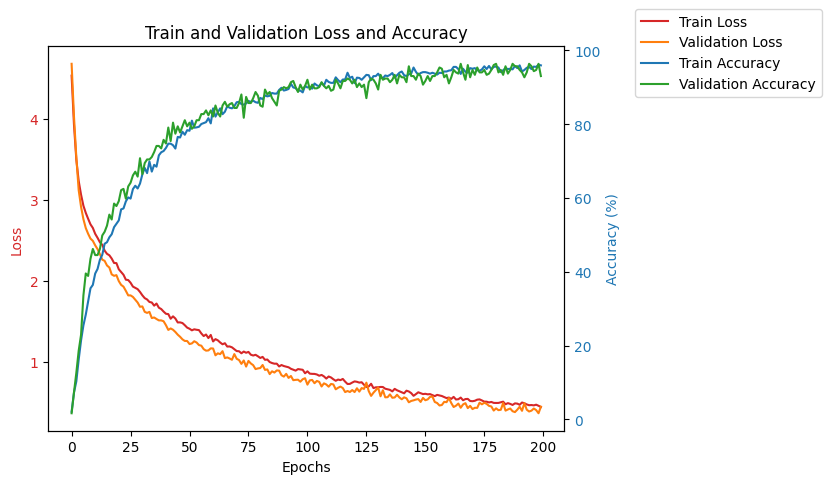

In [24]:
import matplotlib.pyplot as plt

# ------------------ Vẽ biểu đồ ------------------
fig, ax1 = plt.subplots()

# Vẽ train loss và validation loss với trục y1
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(range(NUM_EPOCHS), train_losses, color='tab:red', label='Train Loss')
ax1.plot(range(NUM_EPOCHS), val_losses, color='tab:orange', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Tạo trục y2 cho accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(range(NUM_EPOCHS), train_accuracies, color='tab:blue', label='Train Accuracy')
ax2.plot(range(NUM_EPOCHS), val_accuracies, color='tab:green', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Thêm tiêu đề
plt.title('Train and Validation Loss and Accuracy')

# Thêm chú thích (legend) ở ngoài biểu đồ
fig.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

# Tự động điều chỉnh layout để không bị chồng lên nhau
fig.tight_layout()

# Hiển thị đồ thị
plt.show()


Vẽ confution matrix

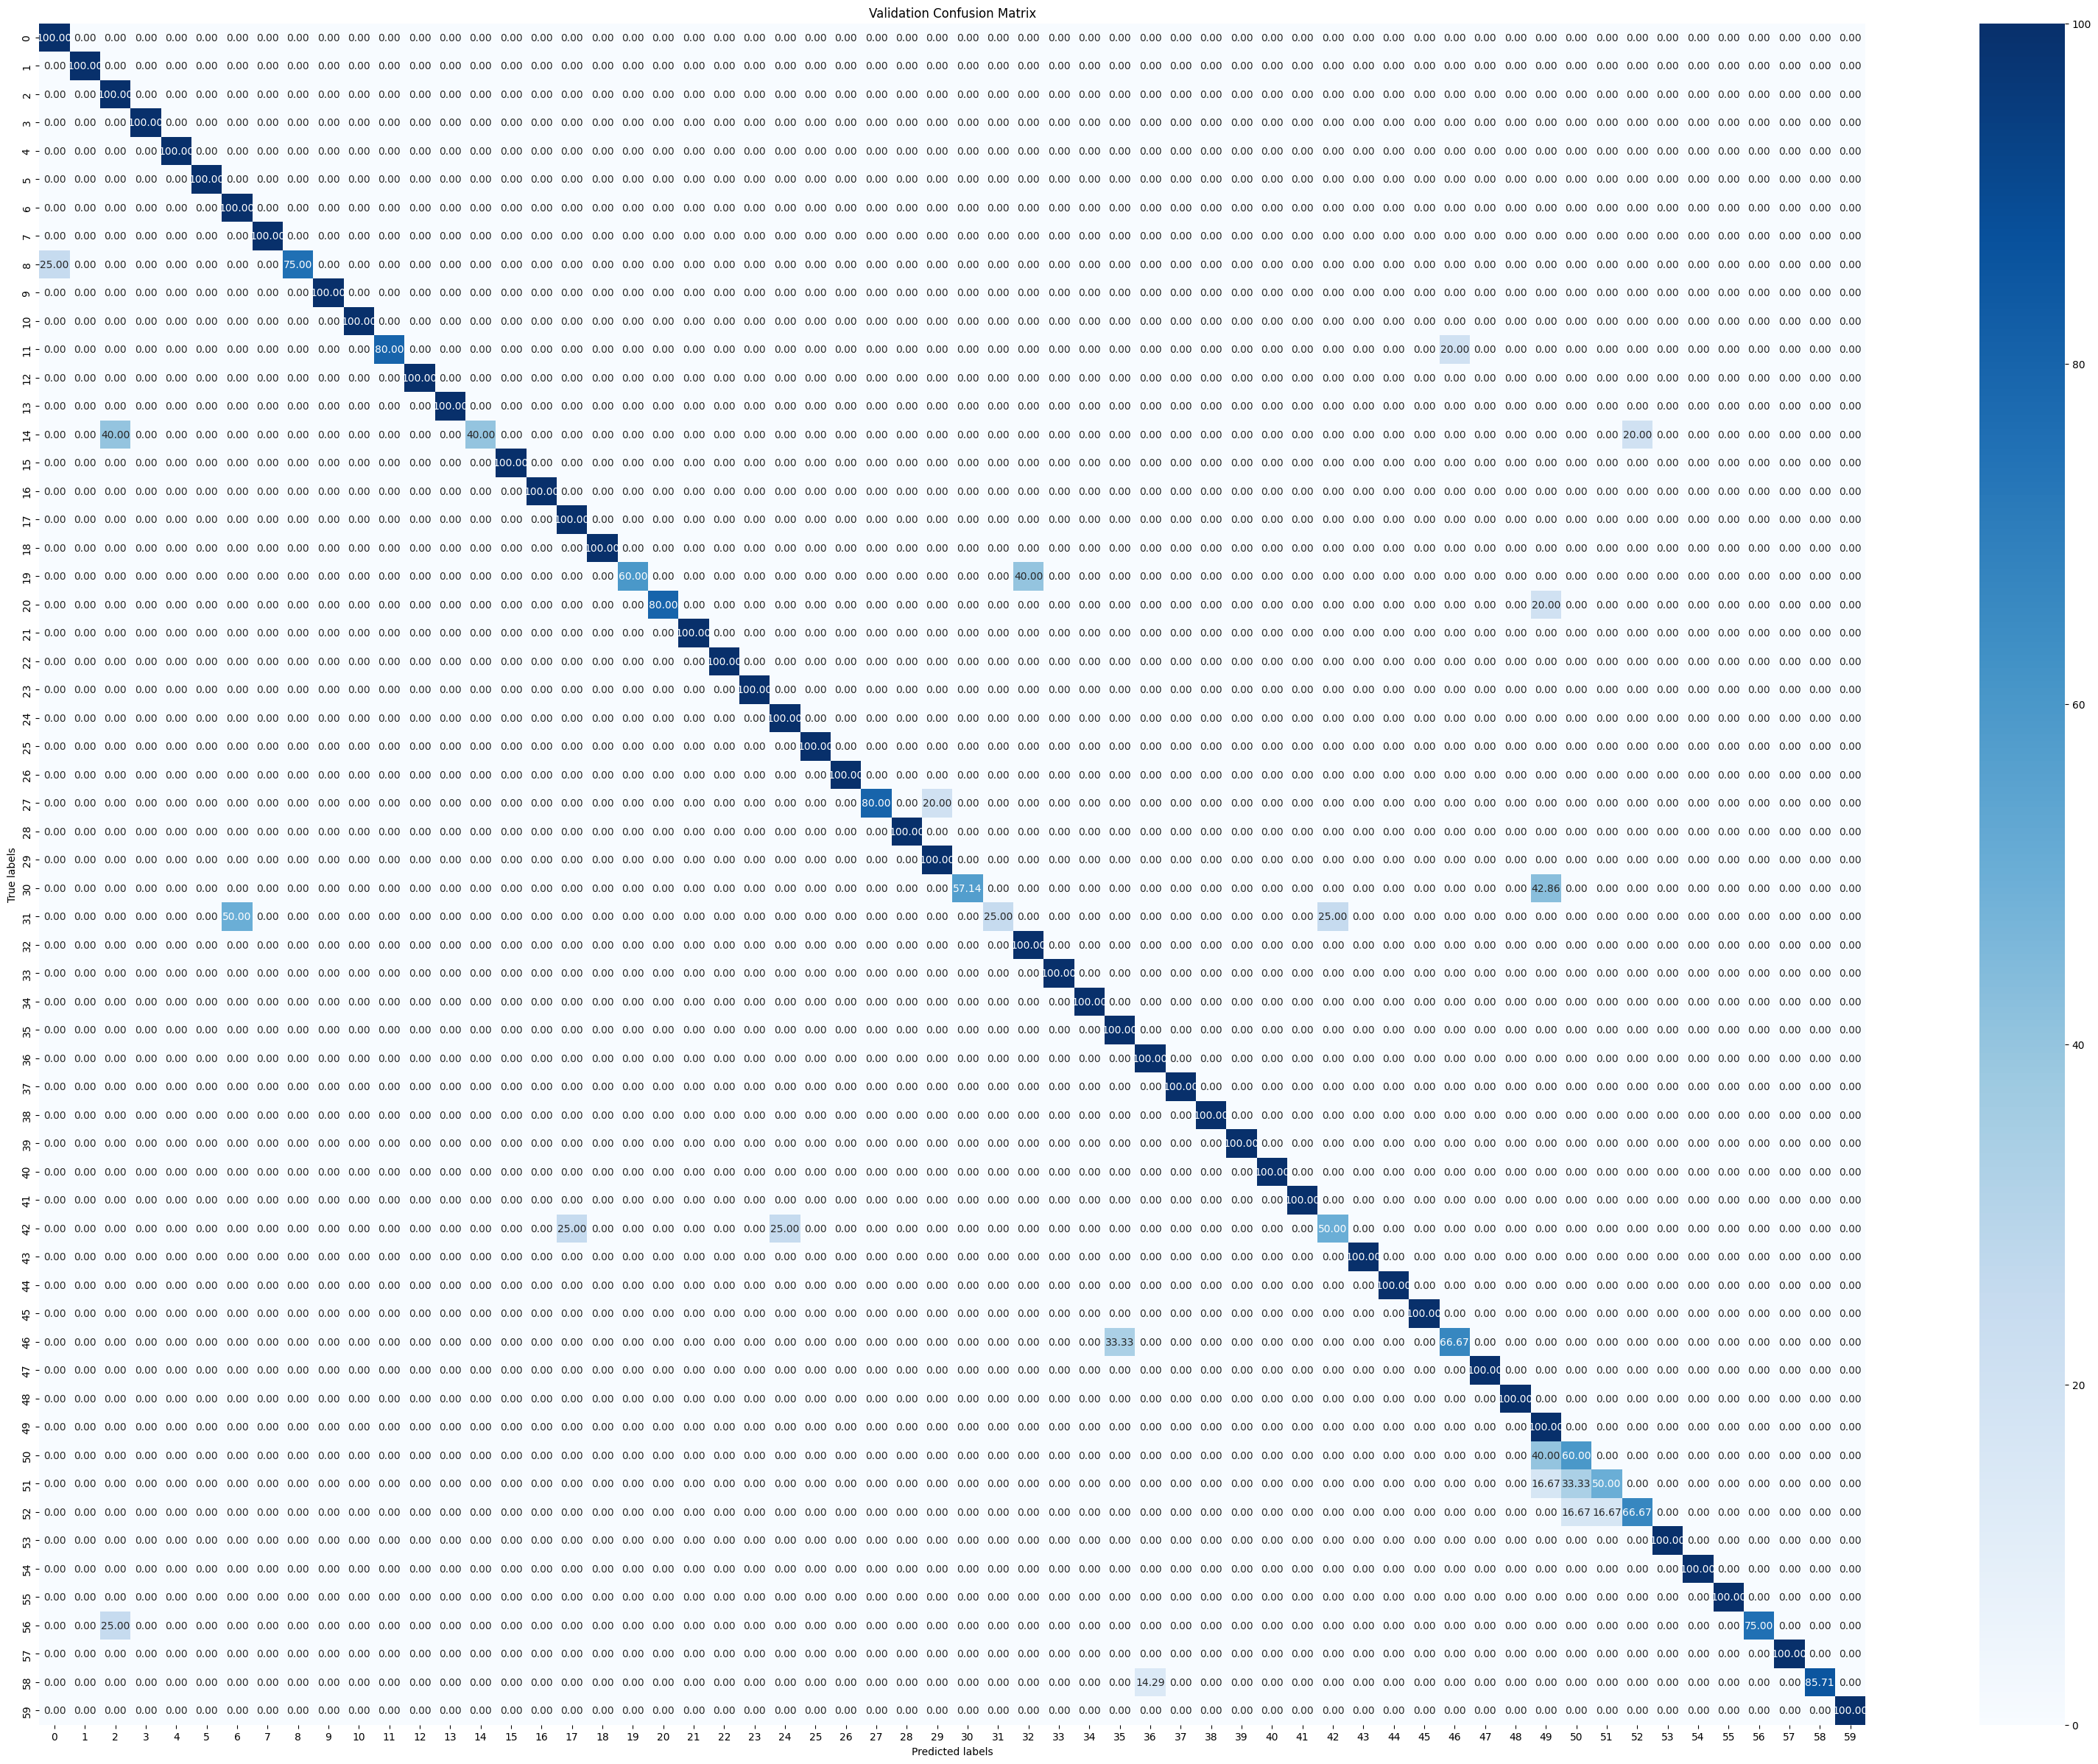

In [26]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

# Hàm vẽ Confusion Matrix theo phần trăm
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Chuyển sang phần trăm
    plt.figure(figsize=(40, 30))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# ------------------ Đánh giá trên tập validation ------------------
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)

        # Dự đoán
        outputs = model(videos)
        _, predicted = torch.max(outputs, 1)

        # Lưu lại dự đoán và nhãn thật
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

labels = [str(i) for i in range(len(set(all_labels)))]

# Vẽ Confusion Matrix
plot_confusion_matrix(cm, labels, title='Validation Confusion Matrix')


In [27]:
print('accuracy:', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1-score: ', f1)

accuracy: 0.9069767441860465
precision:  0.9301297263091283
recall:  0.9069767441860465
f1-score:  0.9046017138356398


Xây dựng mô hình LSTM kết hợp Multi Head Attention, sử dụng thêm kĩ thuật skip connect

In [28]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_size, num_heads)

    def forward(self, x, mask=None):
        x = x.transpose(0, 1)
        attn_output, _ = self.attention(x, x, x, attn_mask=mask)
        return attn_output.transpose(0, 1)  # Chuyển lại thứ tự từ (T, N, E) về (N, T, E)

class LSTM_RESEDUAL_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.1, bidirectional=True, num_heads=8):
        super(LSTM_RESEDUAL_Model, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.residual_fc = nn.Linear(input_size, hidden_size)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True,
                            dropout=dropout, bidirectional=bidirectional)
        self.bn_lstm = nn.BatchNorm1d(hidden_size * 2 if bidirectional else hidden_size)
        self.residual_lstm = nn.Linear(hidden_size, hidden_size * 2 if bidirectional else hidden_size)

        self.attention = MultiHeadAttention(hidden_size * 2 if bidirectional else hidden_size, num_heads=num_heads)

        self.fc_out = nn.Linear(hidden_size * 2, num_classes)

        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(0.3)

        # Layer Normalization
        self.ln_lstm = nn.LayerNorm(hidden_size * 2 if bidirectional else hidden_size)
        self.ln_fc = nn.LayerNorm(num_classes)

    def forward(self, x):
        N, T, V, C = x.size()

        x = x.view(N, T, V * C)
        residual = x

        x = self.fc1(x)
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.relu(x)
        x = self.dropout(x)

        x = x + self.residual_fc(residual)
        residual = x

        x, (hn, cn) = self.lstm(x)
        x = self.bn_lstm(x.transpose(1, 2)).transpose(1, 2)


        x = self.ln_lstm(x)

        x = self.attention(x)

        x_out = self.fc_out(x[:, -1, :])

        x_out = self.ln_fc(x_out)

        return x_out


In [29]:
input_size = dataset[0][0].shape[2] * dataset[0][0].shape[1]   # V*C (số khớp * số tọa độ)
hidden_size = 128  # Số lượng đơn vị ẩn trong LSTM
num_layers = 3  # Số lượng lớp LSTM
num_classes = len(set(dataset.labels))  # Số lớp phân loại (tương ứng với số nhãn)
dropout=0.5
model = LSTM_RESEDUAL_Model(input_size, hidden_size, num_layers, num_classes, dropout=dropout)
num_classes

60

Tính độ phức tạp tính toán (flops) và số parameter của mô hình

In [30]:
from thop import profile
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPS: {flops/1000000000} GFlops")
print(f"Parameters: {params}")

[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
FLOPS: 0.03569176 GFlops
Parameters: 1123252.0


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

In [32]:
model.to(device)

LSTM_RESEDUAL_Model(
  (fc1): Linear(in_features=201, out_features=128, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_fc): Linear(in_features=201, out_features=128, bias=True)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (bn_lstm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (residual_lstm): Linear(in_features=128, out_features=256, bias=True)
  (attention): MultiHeadAttention(
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
  )
  (fc_out): Linear(in_features=256, out_features=60, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (ln_lstm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln_fc): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
)

In [33]:
best_val_accuracy = 0.0
best_model_path = "/content/drive/MyDrive/TLCN/model/best_model_lstm_resedual_attention.pth"

os.makedirs('/content/drive/MyDrive/TLCN/model', exist_ok=True)

Huấn luyện mô hình

In [34]:
import matplotlib.pyplot as plt
NUM_EPOCHS=200
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # ------------------ Huấn luyện ------------------
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(videos)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Tính accuracy
    train_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(running_loss / len(train_loader))  # Average loss over the epoch
    train_accuracies.append(train_accuracy)

    # ------------------ Đánh giá trên tập validation ------------------
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    val_accuracy = 100 * correct_predictions / total_predictions
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"Saving best model with Val Accuracy: {best_val_accuracy:.2f}%")
        # torch.save(model.state_dict(), best_model_path)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')


Saving best model with Val Accuracy: 1.66%
Epoch [1/200], Train Loss: 4.3535, Train Accuracy: 2.75%, Validation Loss: 4.4793, Validation Accuracy: 1.66%
Saving best model with Val Accuracy: 3.99%
Epoch [2/200], Train Loss: 3.8595, Train Accuracy: 7.90%, Validation Loss: 3.9694, Validation Accuracy: 3.99%
Saving best model with Val Accuracy: 9.63%
Epoch [3/200], Train Loss: 3.5165, Train Accuracy: 11.40%, Validation Loss: 3.4824, Validation Accuracy: 9.63%
Saving best model with Val Accuracy: 16.28%
Epoch [4/200], Train Loss: 3.2324, Train Accuracy: 17.22%, Validation Loss: 3.1865, Validation Accuracy: 16.28%
Saving best model with Val Accuracy: 22.59%
Epoch [5/200], Train Loss: 3.1293, Train Accuracy: 20.13%, Validation Loss: 3.0216, Validation Accuracy: 22.59%
Saving best model with Val Accuracy: 23.92%
Epoch [6/200], Train Loss: 3.0106, Train Accuracy: 25.21%, Validation Loss: 2.8991, Validation Accuracy: 23.92%
Saving best model with Val Accuracy: 30.23%
Epoch [7/200], Train Loss: 2

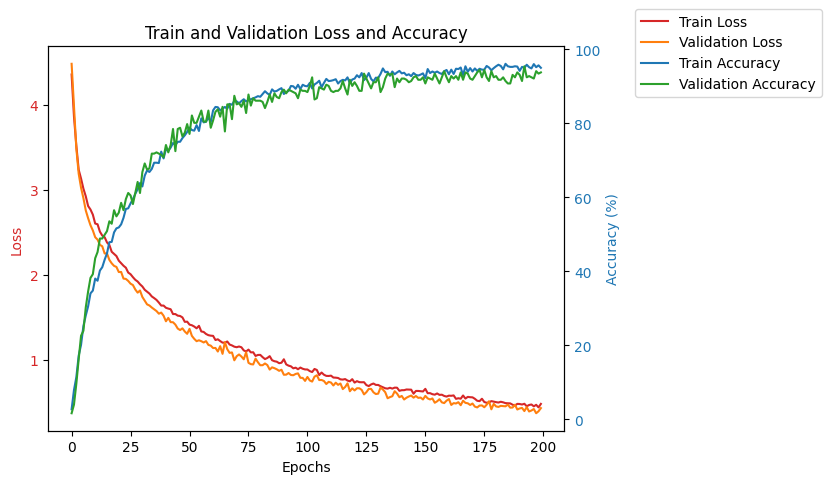

In [35]:
import matplotlib.pyplot as plt

# ------------------ Vẽ biểu đồ ------------------
fig, ax1 = plt.subplots()

# Vẽ train loss và validation loss với trục y1
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(range(NUM_EPOCHS), train_losses, color='tab:red', label='Train Loss')
ax1.plot(range(NUM_EPOCHS), val_losses, color='tab:orange', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Tạo trục y2 cho accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(range(NUM_EPOCHS), train_accuracies, color='tab:blue', label='Train Accuracy')
ax2.plot(range(NUM_EPOCHS), val_accuracies, color='tab:green', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Thêm tiêu đề
plt.title('Train and Validation Loss and Accuracy')

# Thêm chú thích (legend) ở ngoài biểu đồ
fig.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

# Tự động điều chỉnh layout để không bị chồng lên nhau
fig.tight_layout()

# Hiển thị đồ thị
plt.show()


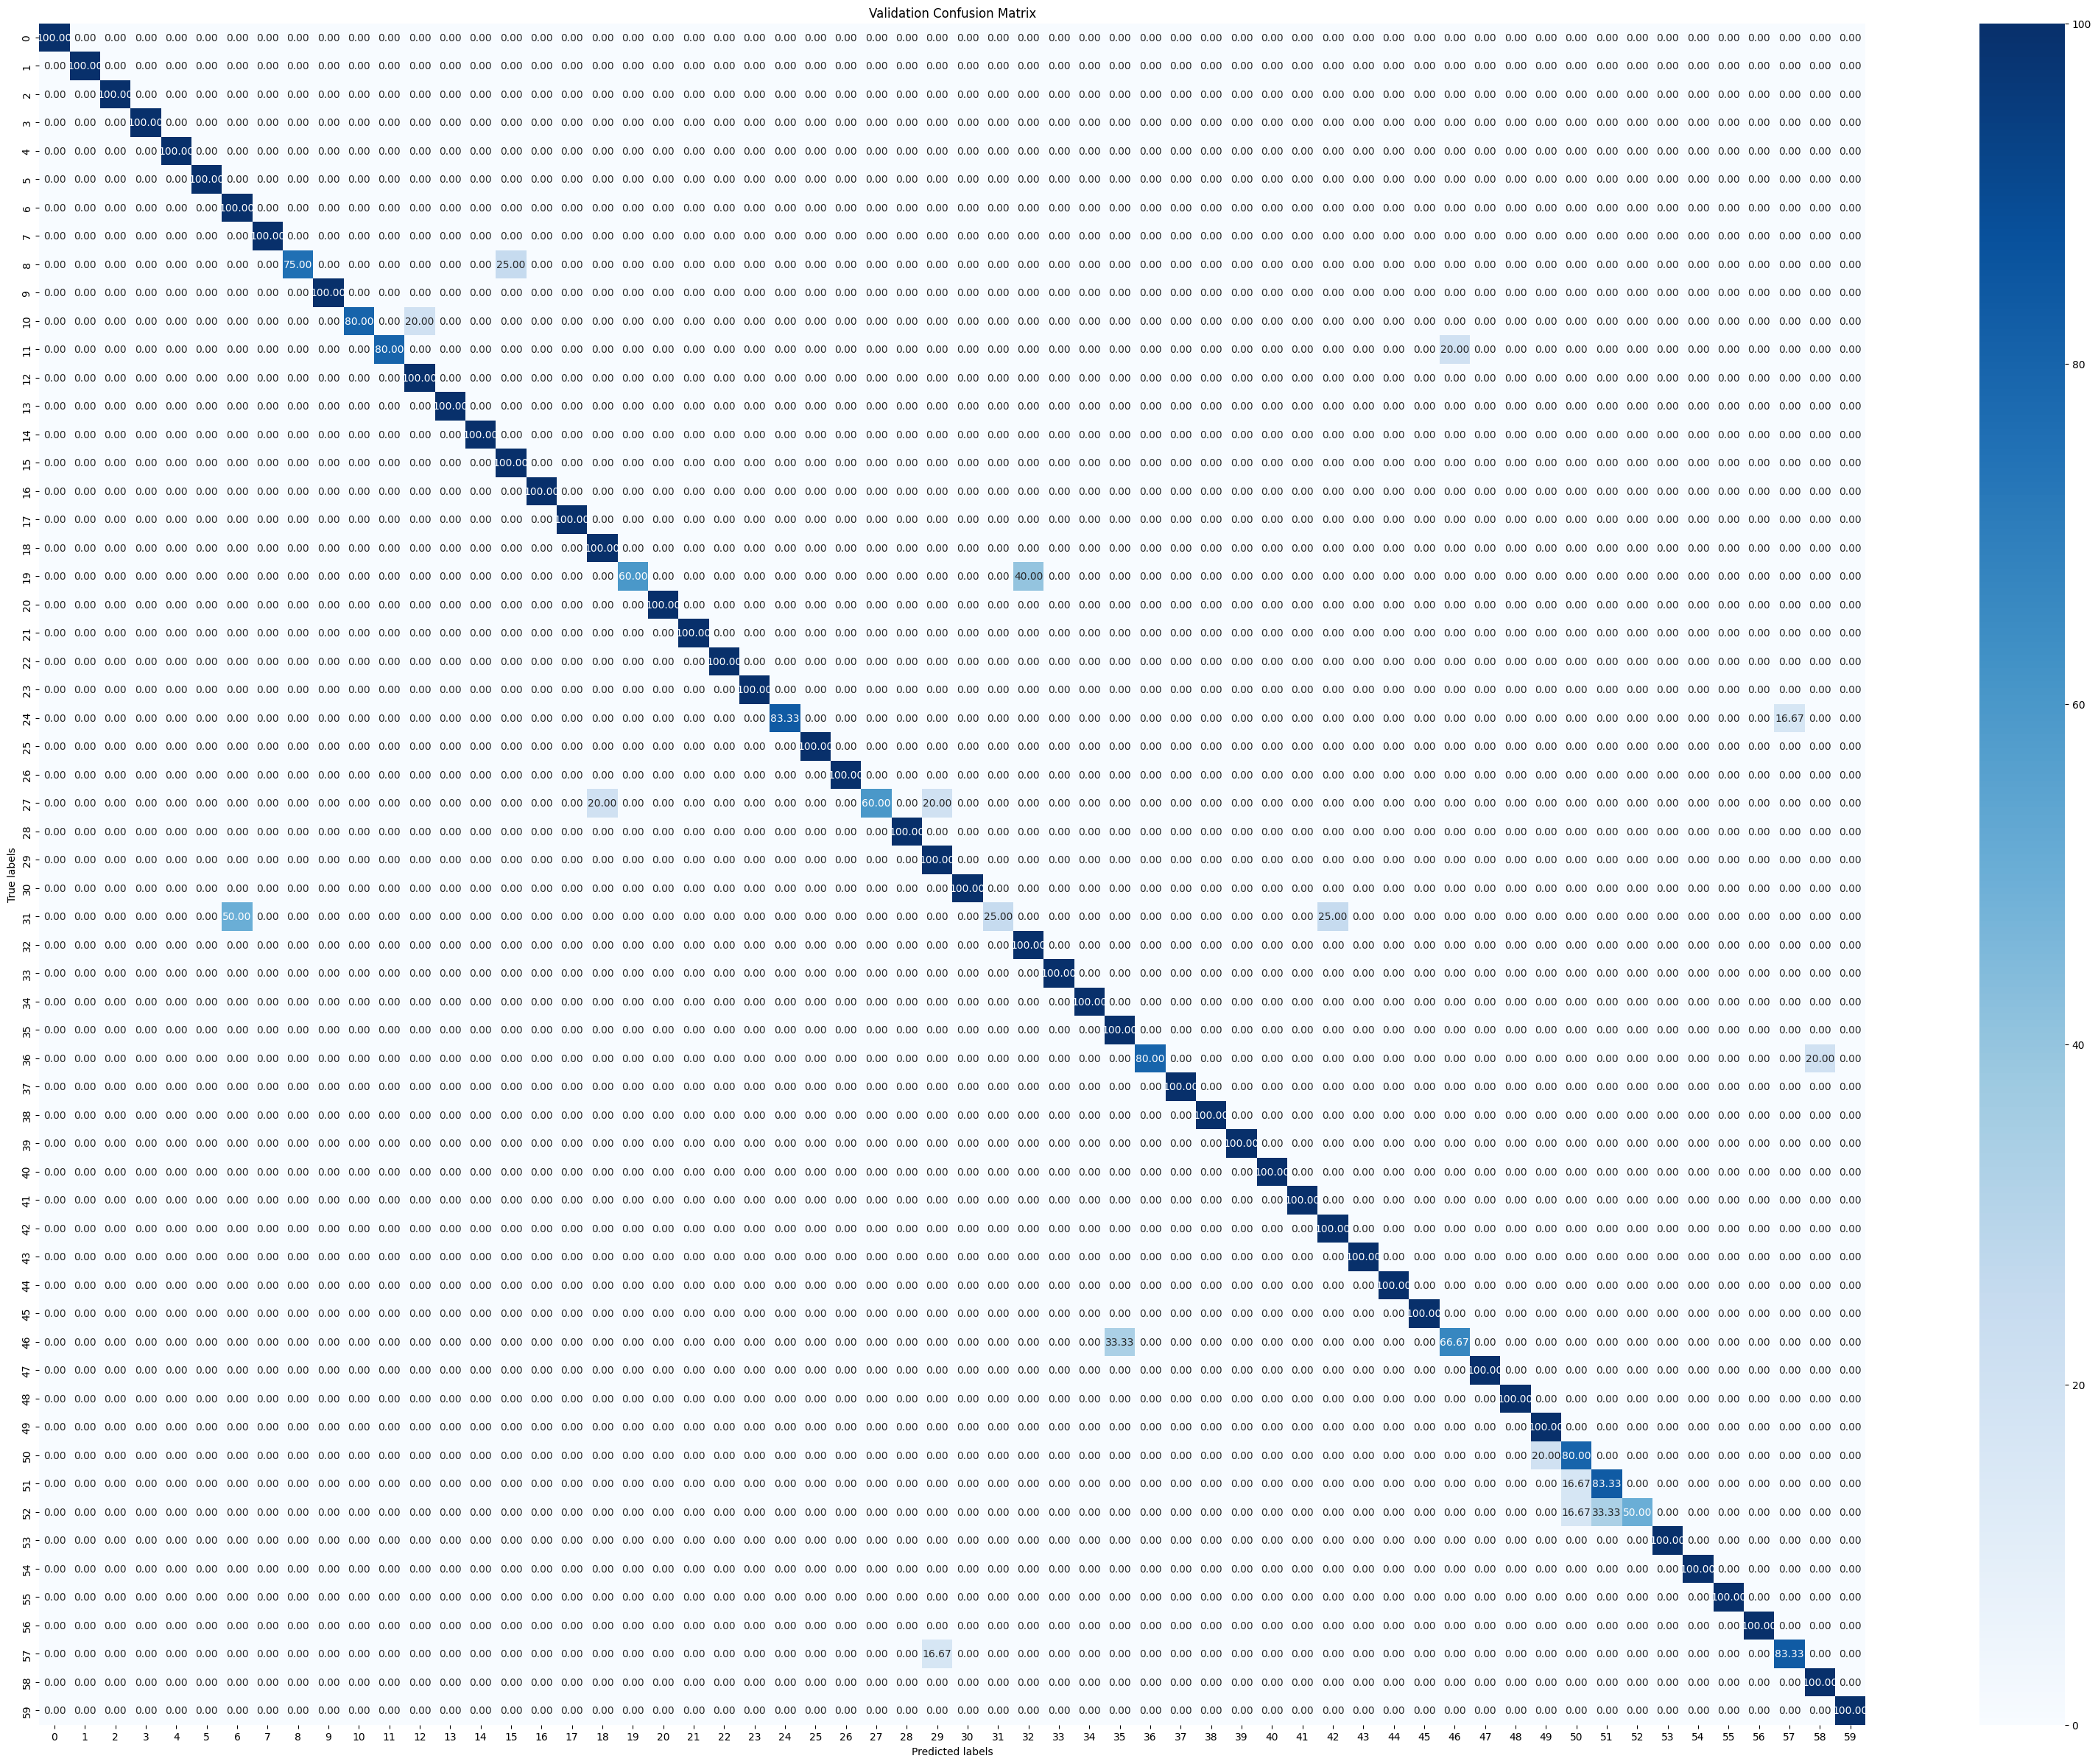

In [36]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hàm vẽ Confusion Matrix theo phần trăm
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Chuyển sang phần trăm
    plt.figure(figsize=(40, 30))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# ------------------ Đánh giá trên tập validation ------------------
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for videos, labels in val_loader:
        videos, labels = videos.to(device), labels.to(device)

        # Dự đoán
        outputs = model(videos)
        _, predicted = torch.max(outputs, 1)

        # Lưu lại dự đoán và nhãn thật
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Tính toán Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

labels = [str(i) for i in range(len(set(all_labels)))]

# Vẽ Confusion Matrix
plot_confusion_matrix(cm, labels, title='Validation Confusion Matrix')


In [37]:
print('accuracy:', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1-score: ', f1)

accuracy: 0.9335548172757475
precision:  0.9459935136845435
recall:  0.9335548172757475
f1-score:  0.9298623119221127
